# TVE Postprocessing

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import rasterio

from pathlib import Path
from rasterio.plot import show
sns.set_theme(style="darkgrid")

%matplotlib inline

In [7]:
data_path = Path(".").resolve().parent / "vina_del_mar" / "output_20220624" / "vina_del_mar_vertical75_dt480" / "1"

In [14]:
pedestrians = pd.read_csv(data_path / "pedestrians.csv")
initial_population_distr = rasterio.open(data_path / "initial_population_distribution.asc")

In [17]:
show(initial_population_distr)

TypeError: Cannot convert fill_value nan to dtype int32

In [18]:
data_path = Path(".").resolve().parent / "vina_del_mar" / "output"

In [19]:
pede = gpd.read_file(data_path / "pedestrians.shp")
pede.head()

,WHO,COLOR,HEADING,XCOR,YCOR,SHAPE,LABEL,LABELCOLOR,BREED,HIDDEN,...,CURRENROAD,ROADLANE,STARTED,MOVING,INNODE,EVACUATED,DEAD,TOTALDISTA,ENDTIME,geometry
0,5198,55,186.987960,234.861887,306.147086,circle,None,9.9,pedestrians,false,...,None,NaN,None,None,None,None,None,NaN,NaN,POINT (260513.809 6343563.235)
1,5199,15,107.204793,244.001616,316.727064,x,None,9.9,pedestrians,false,...,"0, 4895.0, 4896.0, 4897.0, 4898",0.0,"0, 48","99.0,",4900,".0, 4",901.0,0.0,203.0,POINT (260559.508 6343616.135)
2,5200,55,116.482064,228.044693,274.604591,circle,None,9.9,pedestrians,false,...,None,NaN,None,None,None,None,None,NaN,NaN,POINT (260479.723 6343405.523)
3,5201,15,186.414926,208.893418,321.352217,x,None,9.9,pedestrians,false,...,"5.0, 2033.0, 2032.0, 2034.0, 20",3.0,"6.0,",2031.,"0, 20","28.0,",2026,0.0,0.0,POINT (260383.967 6343639.261)
4,5202,55,231.822801,233.579846,212.383762,circle,None,9.9,pedestrians,false,...,None,NaN,None,None,None,None,None,NaN,NaN,POINT (260507.399 6343094.419)


In [22]:
pede.columns

Index(['WHO', 'COLOR', 'HEADING', 'XCOR', 'YCOR', 'SHAPE', 'LABEL',
       'LABELCOLOR', 'BREED', 'HIDDEN', 'SIZE', 'PENSIZE', 'PENMODE', 'INITX',
       'INITY', 'AGE', 'DEPARTIME', 'BASESPEED', 'SPEED', 'SLOPEFACTO',
       'DECISION', 'INITDECISI', 'ROUTE', 'GOALSHELTE', 'CURRENNODE',
       'NEXTNODE', 'CURRENROAD', 'ROADLANE', 'STARTED', 'MOVING', 'INNODE',
       'EVACUATED', 'DEAD', 'TOTALDISTA', 'ENDTIME', 'geometry'],
      dtype='object')

<AxesSubplot:>

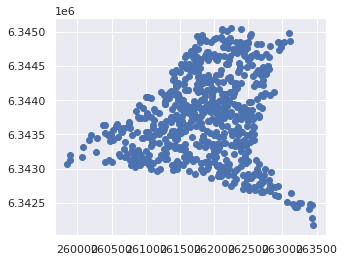

In [20]:
pede.plot()

In [23]:
shelters = gpd.read_file(data_path / "shelters.shp")
shelters.head()

,WHO,COLOR,HEADING,XCOR,YCOR,SHAPE,LABEL,LABELCOLOR,BREED,HIDDEN,SIZE,PENSIZE,PENMODE,ID,SHELTER,EVACTYPE,CAPACITY,EVACUEECOU,EVACUELIST,geometry
0,448,55,0,362.582517,277.496537,square,None,9.9,nodes,false,12,1,up,253418257,true,vertical,806,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (261152.413 6343419.983)
1,496,55,0,420.339960,476.001366,square,None,9.9,nodes,false,12,1,up,254380616,true,vertical,1632,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (261441.200 6344412.507)
2,535,55,0,552.741336,613.421609,square,None,9.9,nodes,false,12,1,up,253420305,true,horizontal,1000000,30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (262103.207 6345099.608)
3,598,55,0,484.310081,466.348971,square,None,9.9,nodes,false,12,1,up,254554396,true,vertical,35,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (261761.050 6344364.245)
4,1066,55,0,161.432836,218.407404,square,None,9.9,nodes,false,12,1,up,254373577,true,horizontal,1000000,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (260146.664 6343124.537)


<AxesSubplot:>

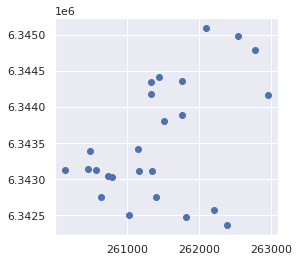

In [24]:
shelters.plot()